In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy import signal

In [ ]:
def deconvolve_waveform(waveform, det_response, regularization=1e-2):
    # Pad response to match length
    n = len(waveform)
    response_padded = np.zeros(n)
    response_padded[:len(det_response)] = det_response

    # FFT
    Y = np.fft.fft(waveform)
    H = np.fft.fft(response_padded)

    # regularization term is to avoid divide-by-zero 
    H_conj = np.conj(H)
    H_abs2 = H * H_conj
    X = Y * H_conj / (H_abs2 + regularization)

    # Inverse FFT 
    recovered = np.fft.ifft(X).real
    return recovered

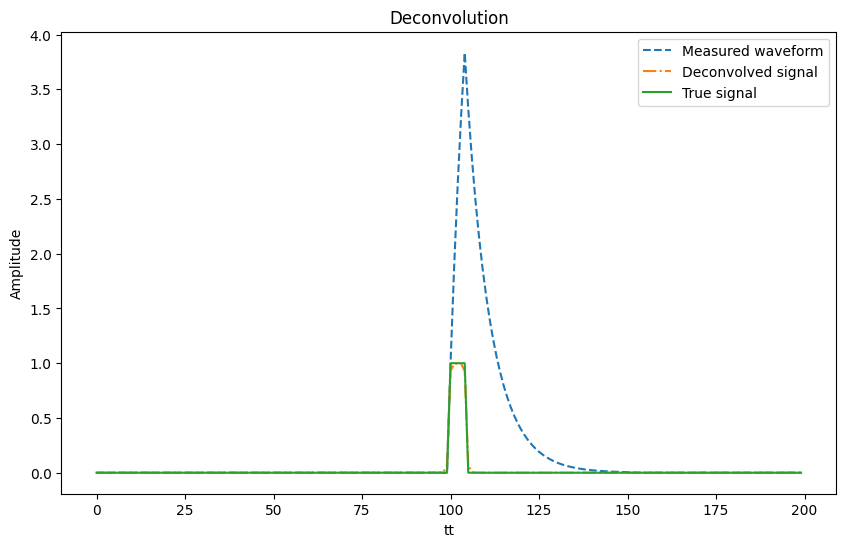

In [ ]:
# Example: synthetic waveform
t = np.arange(200)
true_signal = np.zeros_like(t)
true_signal[100:105] = 1.0  # A square pulse 

# Simulated detector response (e.g., CR-(RC)^n shape)
response = np.exp(-np.arange(50)/7.0)

# Create measured signal by convolving
measured = np.convolve(true_signal, response, mode='full')[:len(t)]

# Deconvolve
recovered = deconvolve_waveform(measured, response, regularization=1e-1)

# Plot
plt.figure(figsize=(10,6))
plt.plot(measured, label="Measured waveform", linestyle='--')
plt.plot(recovered, label="Deconvolved signal", linestyle='-.')
plt.plot(true_signal, label="True signal")
plt.legend()
plt.title("Deconvolution")
plt.xlabel("tt")
plt.ylabel("Amplitude")
plt.show()

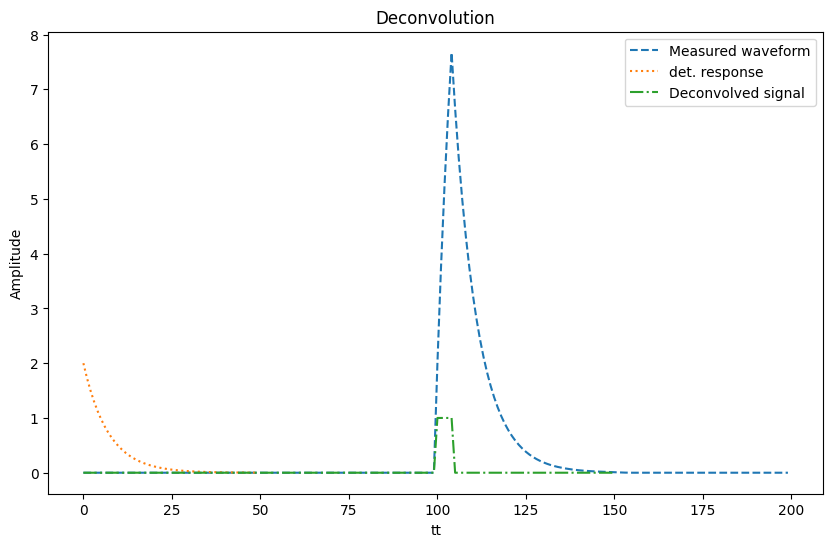

In [4]:
# Example: synthetic waveform
t = np.arange(200)
true_signal = np.zeros_like(t)
true_signal[100:105] = 1.0  # A square pulse 

# Simulated detector response (e.g., CR-(RC)^n shape)
response = 2*np.exp(-np.arange(50)/7.0)

# Create measured signal by convolving
measured = np.convolve(true_signal, response, mode='full')[:len(t)]

# Deconvolve
# recovered = deconvolve_waveform(measured, response, regularization=1e-1)
recovered, remainder = signal.deconvolve(measured, response)

# Plot
plt.figure(figsize=(10,6))
plt.plot(measured, label="Measured waveform", linestyle='--')
plt.plot(response, label="det. response", linestyle=':')
plt.plot(recovered, label="Deconvolved signal", linestyle='-.')
# plt.plot(true_signal, label="True signal")
plt.legend()
plt.title("Deconvolution")
plt.xlabel("tt")
plt.ylabel("Amplitude")
plt.show()

# More realistic

In [5]:
def pad_waveforms(input_data, pad_length=500):
    output_data = input_data
    output_data['waveform_padded'] = [np.pad(wf, (0, pad_length - len(wf))) if len(wf) < pad_length else wf[:pad_length] for wf in output_data['waveform']]
    return output_data


padding = 200

peak_folder = '/Users/emiliebertholet/cernbox/coldbox_data/selected_waveforms'

with open(f'{peak_folder}/selection_cosmics_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
cosmics = pd.DataFrame(dic)
cosmics = pad_waveforms(cosmics, padding)
print(f"cosmics:  {cosmics.shape[0]} peaks, {cosmics.trigger_record.unique().shape[0]} trigger records")

with open(f'{peak_folder}/selection_PNS_neutrons_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS_neutrons = pd.DataFrame(dic)
PNS_neutrons = pad_waveforms(PNS_neutrons, padding)
print(f"PNS_neutrons:  {PNS_neutrons.shape[0]} peaks, {PNS_neutrons.trigger_record.unique().shape[0]} trigger records")

cosmics:  25150 peaks, 4189 trigger records
PNS_neutrons:  3780 peaks, 3187 trigger records


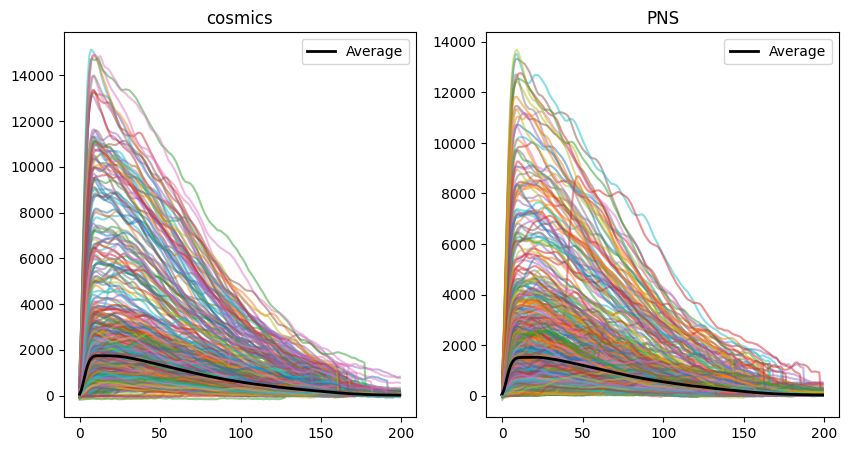

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
waveforms = np.stack(cosmics['waveform_padded'].values)
avg_cr = np.mean(cosmics['waveform_padded'], axis=0)
for w in waveforms[:1000]:
    ax.plot(w, alpha=0.5)
ax.plot(avg_cr, color='black', linewidth=2, label='Average')
ax.set_title('cosmics')
ax.legend();

ax = axs[1]
waveforms = np.stack(PNS_neutrons['waveform_padded'].values)
avg_pns = np.mean(PNS_neutrons['waveform_padded'], axis=0)
for w in waveforms[:1000]:
    ax.plot(w, alpha=0.5)
ax.plot(avg_pns, color='black', linewidth=2, label='Average')
ax.set_title('PNS')
ax.legend();



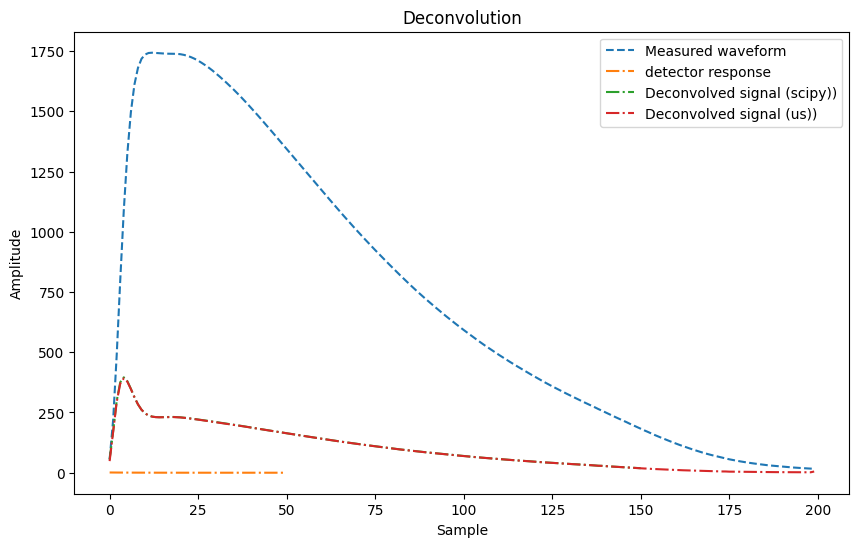

In [7]:
t = np.arange(200)

N = 1
tau = 7.0
response = N*np.exp(-np.arange(50)/tau)
# N: the larger, the smaller the amplitude of the deconvoluted signal



waveform = avg_cr

recovered = deconvolve_waveform(waveform, response, regularization=1e-1)
recovered_scipy, remainder = signal.deconvolve(waveform, response)

# Plot
plt.figure(figsize=(10,6))
plt.plot(waveform, label="Measured waveform", linestyle='--')
plt.plot(response, label="detector response", linestyle='-.')
plt.plot(recovered_scipy, label="Deconvolved signal (scipy))", linestyle='-.')
plt.plot(recovered, label="Deconvolved signal (us))", linestyle='-.')

plt.legend()
plt.title("Deconvolution")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

## Detector response study

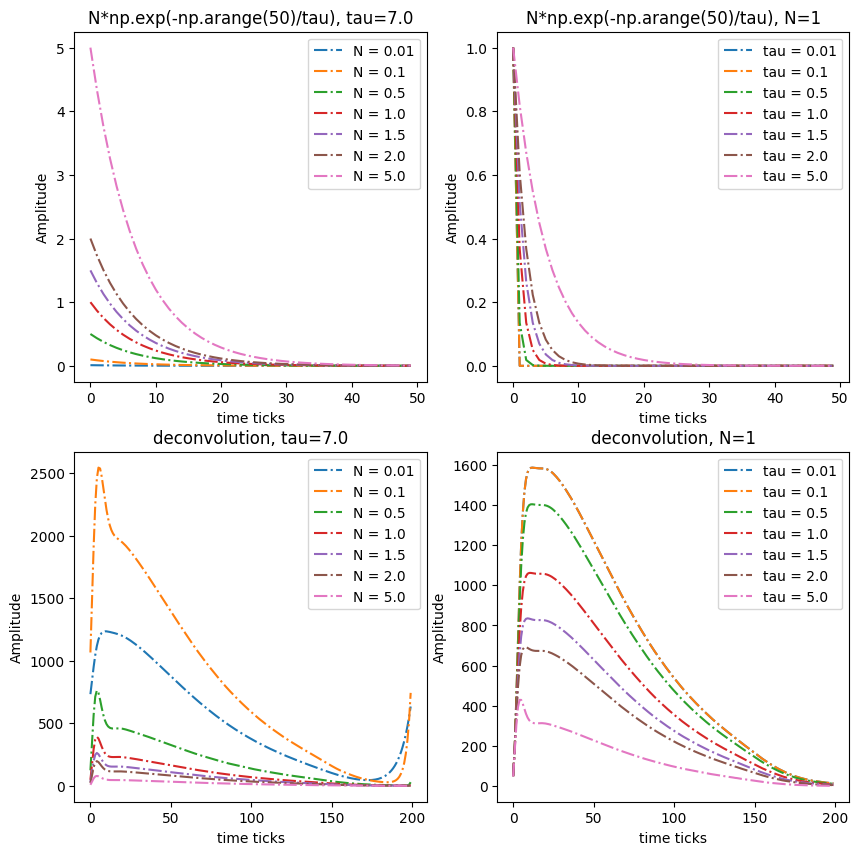

In [ ]:

waveform = avg_cr


def det_response(N, tau):
    return N*np.exp(-np.arange(50)/tau)



# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ax= axs.flatten()[0]
for N in [0.01, 0.1, 0.5, 1., 1.5, 2., 5.]:
    tau = 7.0
    response = det_response(N, tau)
    ax.plot(response, label=f"N = {N}", linestyle='-.')
ax.legend()
ax.set_title("N*np.exp(-np.arange(50)/tau), tau=7.0")
ax.set_xlabel("time ticks")
ax.set_ylabel("Amplitude")

ax= axs.flatten()[1]
N = 1
for tau in [0.01, 0.1, 0.5, 1., 1.5, 2., 5.]:
    response = det_response(N, tau)
    ax.plot(response, label=f"tau = {tau}", linestyle='-.')
ax.legend()
ax.set_title("N*np.exp(-np.arange(50)/tau), N=1")
ax.set_xlabel("time ticks")
ax.set_ylabel("Amplitude")

ax= axs.flatten()[2]
for N in [0.01, 0.1, 0.5, 1., 1.5, 2., 5.]:
    tau = 7.0
    response = det_response(N, tau)
    recovered = deconvolve_waveform(waveform, response, regularization=1e-1)
    ax.plot(recovered, label=f"N = {N}", linestyle='-.')
ax.legend()
ax.set_title("deconvolution, tau=7.0")
ax.set_xlabel("time ticks")
ax.set_ylabel("Amplitude")

ax= axs.flatten()[3]
N = 1
for tau in [0.01, 0.1, 0.5, 1., 1.5, 2., 5.]:
    response = det_response(N, tau)
    recovered = deconvolve_waveform(waveform, response, regularization=1e-1)
    ax.plot(recovered, label=f"tau = {tau}", linestyle='-.')
ax.legend()
ax.set_title("deconvolution, N=1")
ax.set_xlabel("time ticks")
ax.set_ylabel("Amplitude")

plt.show()

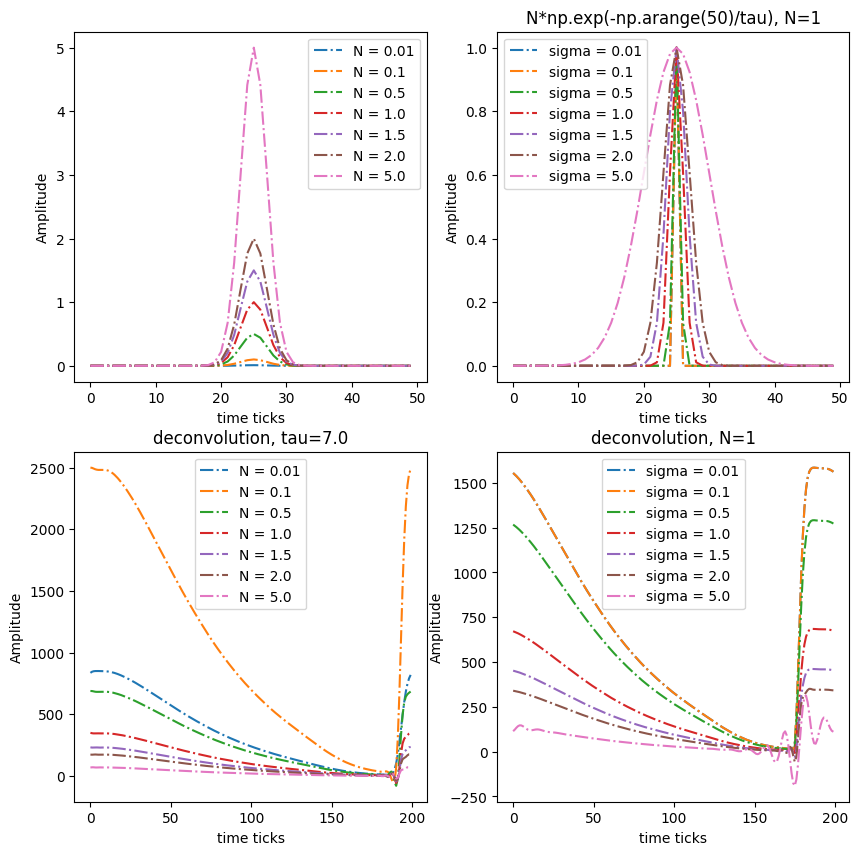

In [33]:

waveform = avg_cr


def det_response(mu=0.0, sigma=1.0, Norm=1.0):
    x=np.arange(50)
    return Norm * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ax= axs.flatten()[0]
for N in [0.01, 0.1, 0.5, 1., 1.5, 2., 5.]:
    response = det_response(mu=25.0, sigma=2.0, Norm=N)
    ax.plot(response, label=f"N = {N}", linestyle='-.')
ax.legend()
ax.set_title("")
ax.set_xlabel("time ticks")
ax.set_ylabel("Amplitude")

ax= axs.flatten()[1]
N = 1
for sigma in [0.01, 0.1, 0.5, 1., 1.5, 2., 5.]:
    response = det_response(mu=25.0, sigma=sigma, Norm=1.)
    ax.plot(response, label=f"sigma = {sigma}", linestyle='-.')
ax.legend()
ax.set_title("N*np.exp(-np.arange(50)/tau), N=1")
ax.set_xlabel("time ticks")
ax.set_ylabel("Amplitude")

ax= axs.flatten()[2]
for N in [0.01, 0.1, 0.5, 1., 1.5, 2., 5.]:
    tau = 7.0
    response = det_response(mu=10.0, sigma=2.0, Norm=N)
    recovered = deconvolve_waveform(waveform, response, regularization=1e-1)
    ax.plot(recovered, label=f"N = {N}", linestyle='-.')
ax.legend()
ax.set_title("deconvolution, tau=7.0")
ax.set_xlabel("time ticks")
ax.set_ylabel("Amplitude")

ax= axs.flatten()[3]
N = 1
for sigma in [0.01, 0.1, 0.5, 1., 1.5, 2., 5.]:
    response = det_response(mu=25.0, sigma=sigma, Norm=1.)
    recovered = deconvolve_waveform(waveform, response, regularization=1e-1)
    ax.plot(recovered, label=f"sigma = {sigma}", linestyle='-.')
ax.legend()
ax.set_title("deconvolution, N=1")
ax.set_xlabel("time ticks")
ax.set_ylabel("Amplitude")

plt.show()